In [361]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Correlation
from scipy.stats import chi2_contingency
import seaborn as sns

# PCA
from sklearn.decomposition import PCA

# KMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score,calinski_harabasz_score 

# KNN
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Random Forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# fuzzy matching
from thefuzz import process

import os

In [362]:
valuations_df = pd.read_csv("big-5-age-valuation-data/Bundesliga_League_Player_Valuations_2019_2024.csv")
filepath = "combined_data/Bundesliga_Scouting_Data_outfield_stats.csv"
outfield_df = pd.read_csv(filepath)

# Extract just the filename (e.g., 'Serie_A_Scouting_Data_outfield_stats.csv')
filename = os.path.basename(filepath)

# Remove the suffix to get 'Serie_A_Scouting_Data'
league_with_suffix = filename.replace('_outfield_stats.csv', '')

# If you want to remove the trailing '_Scouting_Data' and just keep 'Serie_A'
league_name = league_with_suffix.replace('_Scouting_Data', '')

# print number of rows in outfield_df
print(outfield_df.shape[0])

2342


# Preprocessing

In [363]:
# Parameters
MINUTE_CUT_OFF = 450 # 5 games
AGE_VALUATION_YEAR = 2024
YEAR_STRING = "2024-2025"

In [364]:
# only consider 2024 season, the column of scouting period must have the string "2024-2025"
# outfield_df = outfield_df[outfield_df['scouting_period'].str.contains(YEAR_STRING)]
# print(f"Number of outfield player records after filtering: {len(outfield_df)}")


Remove duplicates

In [365]:
print(f"Number of outfield player records before dropping duplicates: {len(outfield_df)}")
outfield_df = outfield_df.drop_duplicates()
print(f"Number of outfield player records after dropping duplicates: {len(outfield_df)}")

Number of outfield player records before dropping duplicates: 2342
Number of outfield player records after dropping duplicates: 2342


Visualising and dropping rows where with players that didn't play enough for sample to be representative

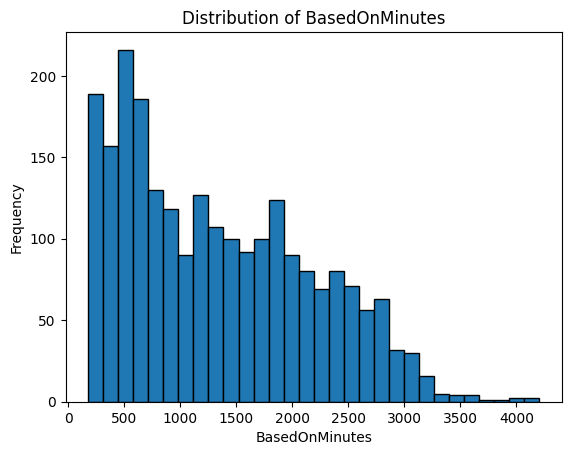

In [366]:
plt.hist(outfield_df['BasedOnMinutes'].dropna(), bins=30, edgecolor='k')
plt.xlabel('BasedOnMinutes')
plt.ylabel('Frequency')
plt.title('Distribution of BasedOnMinutes')
plt.show()

In [367]:
# Dropping all entries with BasedOnMinutes less than MINUTE_CUT_OFF min
print(f"Number of outfield outfield records before filtering: {len(outfield_df)}")
outfield_df = outfield_df[outfield_df['BasedOnMinutes'] >= MINUTE_CUT_OFF]
print(f"Number of outfield outfield records after filtering: {len(outfield_df)}")

Number of outfield outfield records before filtering: 2342
Number of outfield outfield records after filtering: 1994


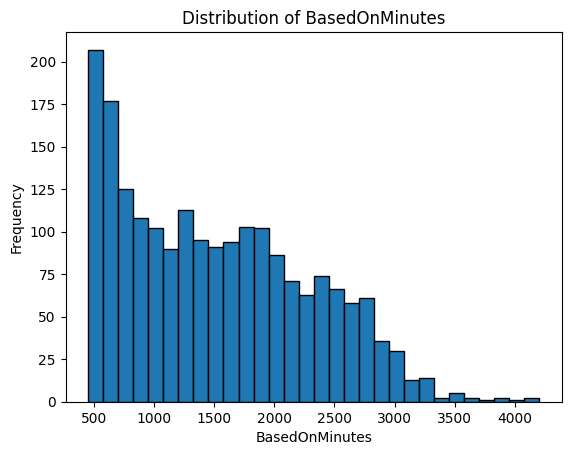

In [368]:
plt.hist(outfield_df['BasedOnMinutes'].dropna(), bins=30, edgecolor='k')
plt.xlabel('BasedOnMinutes')
plt.ylabel('Frequency')
plt.title('Distribution of BasedOnMinutes')
plt.show()

Dropping rows with "Last 365 Days Men's Big 5 Leagues"

In [369]:
# Drop rows where scouting_period is "Last 365 Days Men's Big 5 Leagues"
outfield_df = outfield_df[outfield_df['scouting_period'] != "Last 365 Days Men's Big 5 Leagues"]

Dropping Percentile data 

In [370]:
print(f"Number of outfield player records before dropping Percentile: {outfield_df.shape[1]}")
columns_to_drop = [col for col in outfield_df.columns if 'Percentile' in col]
outfield_df = outfield_df.drop(columns=columns_to_drop)
print(f"Number of outfield player records after dropping Percentile: {outfield_df.shape[1]}")

Number of outfield player records before dropping Percentile: 238
Number of outfield player records after dropping Percentile: 121


Handling na values

In [371]:
null_rows = outfield_df[outfield_df.isnull().any(axis=1)]
null_rows.to_excel('transformed_data/null_rows.xlsx', index=False)

In [372]:
print(f"Number of rows with na values: {len(outfield_df[outfield_df.isnull().any(axis=1)])}")

Number of rows with na values: 214


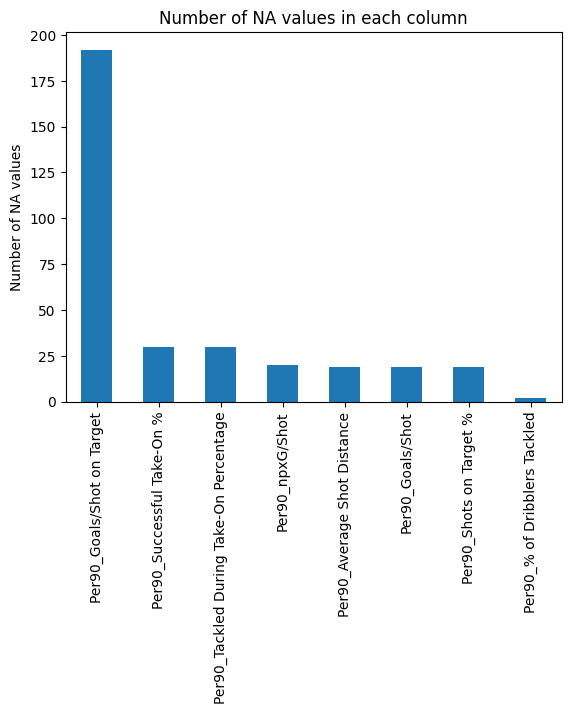

In [373]:
# Visualise columns with na values, sort from highest to lowest
na_columns = outfield_df.isnull().sum()
na_columns = na_columns[na_columns > 0]
na_columns = na_columns.sort_values(ascending=False)
na_columns.plot(kind='bar')
plt.ylabel('Number of NA values')
plt.title('Number of NA values in each column')
plt.show()

In [374]:
# If Per90 is not dropped
na_columns_goal_related_per90 = ['Per90_Goals/Shot on Target', 
                                 'Per90_npxG/Shot', 
                                 'Per90_Average Shot Distance', 
                                 'Per90_Goals/Shot', 
                                 'Per90_Shots on Target %']
na_columns_dribble_related_per90 = ['Per90_Successful Take-On %',
                                    'Per90_Tackled During Take-On Percentage']
na_columns_others = ['Per90_% of Dribblers Tackled',
                    'Per90_% of Aerials Won',
                    'Per90_Pass Completion % (Long)']
def get_existing_columns(df, *column_lists):
    existing_cols = []
    for col_list in column_lists:
        existing_cols.extend([col for col in col_list if col in df.columns])
    return existing_cols

# Get all existing columns from the three lists
existing_columns = get_existing_columns(outfield_df, 
                                        na_columns_goal_related_per90, 
                                        na_columns_dribble_related_per90, 
                                        na_columns_others)

outfield_df[existing_columns] = outfield_df[existing_columns].fillna(0)

In [375]:
print(f"Number of rows with na values: {len(outfield_df[outfield_df.isnull().any(axis=1)])}")

Number of rows with na values: 0


Combining rows to ensure that one entry is tagged to only one unique player

In [376]:
print(outfield_df.dtypes)

Player                             object
Versus                             object
BasedOnMinutes                      int64
scouting_period                    object
Per90_% of Aerials Won            float64
                                   ...   
Per90_npxG/Shot                   float64
Per90_npxG: Non-Penalty xG        float64
Per90_xA: Expected Assists        float64
Per90_xAG: Exp. Assisted Goals    float64
Per90_xG: Expected Goals          float64
Length: 121, dtype: object


In [377]:
# Drop non-numeric column "scouting_period"
outfield_df = outfield_df.drop(columns=["scouting_period"], errors="ignore")

# Define numeric columns excluding categorical ones
numeric_cols = [col for col in outfield_df.columns if col not in ['Player', 'Versus', 'BasedOnMinutes']]

# Compute weighted averages for numeric stats
weighted_avg_df = outfield_df.groupby("Player").apply(
    lambda group: pd.Series(
        {col: np.average(group[col], weights=group["BasedOnMinutes"]) for col in numeric_cols}
    )
).reset_index()

# Drop "BasedOnMinutes" since it's no longer needed
outfield_df = weighted_avg_df.drop(columns=["BasedOnMinutes"], errors="ignore")

outfield_df.head(10)

,Player,Per90_% of Aerials Won,Per90_% of Dribblers Tackled,Per90_Aerials Lost,Per90_Aerials Won,Per90_Assists,Per90_Average Shot Distance,Per90_Ball Recoveries,Per90_Blocks,Per90_Carries,...,Per90_Touches (Def Pen),Per90_Touches (Live-Ball),Per90_Touches (Mid 3rd),Per90_Yellow Cards,Per90_npxG + xAG,Per90_npxG/Shot,Per90_npxG: Non-Penalty xG,Per90_xA: Expected Assists,Per90_xAG: Exp. Assisted Goals,Per90_xG: Expected Goals
0,Adrian Beck,53.972337,36.614787,1.578989,1.718989,0.105408,16.847874,7.758506,2.245408,29.356746,...,1.720585,55.167136,28.304058,0.034202,0.279415,0.125201,0.194007,0.100207,0.082400,0.194007
1,Alassane Pléa,32.341598,32.754372,1.843717,0.882956,0.227822,16.565573,3.192249,0.551713,27.028081,...,0.514784,43.308598,20.998234,0.144338,0.512344,0.126050,0.323827,0.174809,0.187992,0.357579
2,Aleix García,50.799601,47.624432,0.621353,0.572930,0.153740,24.899493,5.630709,1.043595,45.166843,...,3.025268,82.539562,46.412870,0.112826,0.253899,0.061618,0.063683,0.184390,0.187318,0.063683
3,Aleksandar Pavlovic,53.312211,56.281123,0.632470,0.692947,0.043053,19.493614,5.071684,1.240940,58.947270,...,1.535902,95.178498,63.408604,0.228716,0.072182,0.085832,0.042526,0.122870,0.029656,0.042526
4,Alexander Bernhardsson,54.500000,76.900000,1.650000,1.980000,0.160000,16.000000,2.970000,1.150000,16.650000,...,1.150000,38.410000,18.790000,0.330000,0.310000,0.130000,0.210000,0.070000,0.100000,0.210000
5,Alexis Claude-Maurice,42.731546,37.861255,0.703653,0.488411,0.133188,19.756262,3.756820,0.773199,30.794724,...,0.654823,46.035330,22.208661,0.141951,0.310292,0.099148,0.204301,0.101548,0.106657,0.204301
6,Aljoscha Kemlein,57.600000,35.700000,1.370000,1.850000,0.000000,17.400000,5.660000,1.370000,25.380000,...,1.560000,53.590000,32.310000,0.290000,0.150000,0.090000,0.090000,0.070000,0.060000,0.090000
7,Alphonso Davies,48.830635,57.486367,0.668007,0.604145,0.193387,19.336656,7.630344,1.257166,48.472581,...,2.267987,78.829775,36.828019,0.082004,0.241165,0.100286,0.084538,0.153004,0.154098,0.084538
8,Amadou Haidara,52.694711,45.666005,1.593252,1.743081,0.052210,22.393342,6.248626,1.882160,32.815682,...,2.522243,65.448447,39.494151,0.272511,0.188421,0.075771,0.097389,0.094701,0.088942,0.097389
9,Ameen Al-Dakhil,38.654777,21.073248,2.294140,1.458089,0.000000,14.678981,4.691274,0.783631,47.946115,...,8.021911,72.181847,34.496561,0.105541,0.120000,0.132803,0.094459,0.050000,0.033312,0.094459


Merge with age_data

In [378]:
age_df = pd.read_csv("data/age_data.csv")

for name in outfield_df['Player']:
    matched_name, score, _ = process.extractOne(name, age_df['Player'])

    if score >= 70:
        outfield_df['Player'] = outfield_df['Player'].replace(name, matched_name)

outfield_df = outfield_df.merge(
    age_df[['Player', 'age']], 
    on="Player", 
    how="left"
)

print(f"Number of na values in Age: {outfield_df['age'].isna().sum()}")
# drop na values
outfield_df = outfield_df.dropna(subset=['age'])
print(f"Number of na values in Age after dropping: {outfield_df['age'].isna().sum()}")

outfield_df.to_csv("preprocessed_data/outfield_processed.csv", index=False)

print("Merging completed successfully!")

Number of na values in Age: 275
Number of na values in Age after dropping: 0
Merging completed successfully!


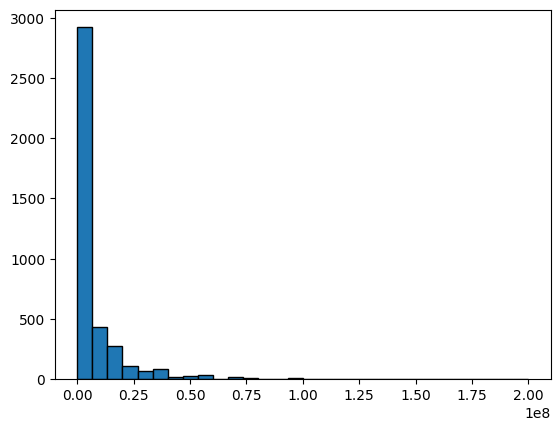

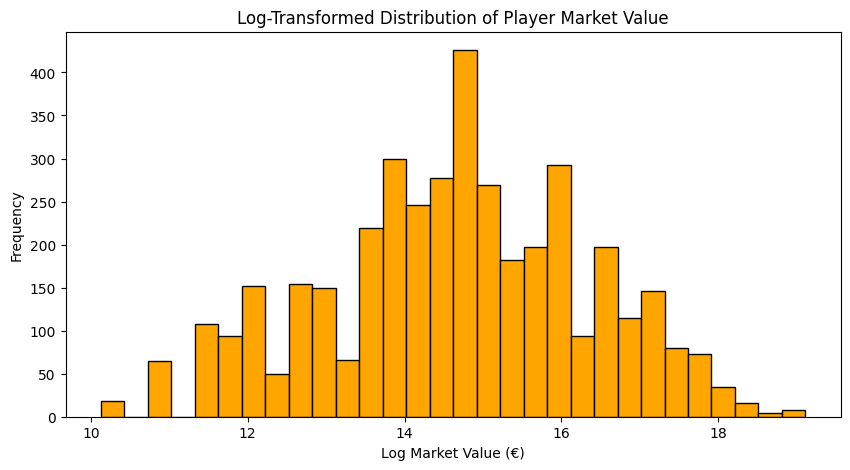

In [379]:

# visualise distribution of player market value
plt.hist(valuations_df['player_market_value_euro'], bins=30, edgecolor='k')

# log visualisation
log_values = np.log1p(valuations_df['player_market_value_euro'])  # log(1 + x) to avoid log(0) issues

# Log visualisation
plt.figure(figsize=(10, 5))
plt.hist(log_values, bins=30, edgecolor='k', color='orange')
plt.xlabel('Log Market Value (€)')
plt.ylabel('Frequency')
plt.title('Log-Transformed Distribution of Player Market Value')
plt.show()

# convert player_market_value to a log scale
valuations_df['player_market_value_euro'] = np.log(valuations_df['player_market_value_euro'])

Log the distribution of player market value

In [380]:
# Rename 'player_name' to 'Player'
valuations_df.rename(columns={"player_name": "Player"}, inplace=True)

# Filter only rows where season_start_year is 2024
valuations_2024_df = valuations_df[valuations_df['season_start_year'] == 2024]

# Change 'Player' value in outfield_df to that in valuations_2024_df if fuzzy matching
for name in outfield_df['Player']:
    matched_name, score, _ = process.extractOne(name, valuations_2024_df['Player'])

    if score >= 70:
        # replace name with best_match
        outfield_df['Player'] = outfield_df['Player'].replace(name, matched_name)

# Merge only player_market_value_euro for 2024 season
outfield_df = outfield_df.merge(
    valuations_2024_df[['Player', 'player_market_value_euro']], 
    on="Player", 
    how="left"
)

# Print number of na values in player_market_value_euro
print(f"Number of na values in player_market_value_euro: {outfield_df['player_market_value_euro'].isna().sum()}")
# drop na values
outfield_df = outfield_df.dropna(subset=['player_market_value_euro'])
print(f"Number of na values in player_market_value_euro after dropping: {outfield_df['player_market_value_euro'].isna().sum()}")

Number of na values in player_market_value_euro: 41
Number of na values in player_market_value_euro after dropping: 0


Merge data with valuation

In [381]:
# # Rename 'player_name' to 'Player'
# valuations_df.rename(columns={"player_name": "Player"}, inplace=True)

# # Filter only rows where season_start_year is 2024
# valuations_2024_df = valuations_df[valuations_df['season_start_year'] == 2024]

# # Change 'Player' value in outfield_df to that in age_valuation_df if fuzzy matching
# for name in outfield_df['Player']:
#     matched_name, score, _ = process.extractOne(name, age_valuation_df['Player'])

#     if score >= 70:
#         # replace name with best_match
#         outfield_df['Player'] = outfield_df['Player'].replace(name, matched_name)

# # Merge only player_market_value_euro for 2024 season
# outfield_df = outfield_df.merge(
#     age_valuation_df[['Player', 'player_market_value_euro']], 
#     on="Player", 
#     how="left"
# )

# # Print number of na values in player_market_value_euro
# print(f"Number of na values in player_market_value_euro: {outfield_df['player_market_value_euro'].isna().sum()}")
# # drop na values
# outfield_df = outfield_df.dropna(subset=['player_market_value_euro'])
# print(f"Number of na values in player_market_value_euro after dropping: {outfield_df['player_market_value_euro'].isna().sum()}")

In [382]:
outfield_df.head()
# save to csv
output_file = os.path.join("preprocessed_data", f"{league_name}_outfield_unique.csv")
outfield_df.to_csv(output_file, index=False)